In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol
from pyscf.grad import RHF as g

In [2]:
import inspect
import sys
sys.path.append("../Libs")
from FcMole import FcM,FcM_like
from FDcoeffs import get_coeffs

In [136]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

The formula for the gradient is stated in Pople's article (Eq.21) as: 
$$ \frac{\partial E}{\partial Z}= \sum_{\mu\nu}P_{\mu\nu}\frac{\partial H_{\mu\nu}}{\partial Z}+\frac{1}{2}\sum_{\mu\nu\lambda\sigma}
P_{\mu\nu}P_{\lambda\sigma}\frac{\partial}{\partial Z}(\mu \lambda | | \nu\sigma)+\frac{\partial V_{nuc}}{\partial Z} 
-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial Z}
$$
$W$ is an energy weighted density matrix:
$$ W_{\mu\nu}= \sum_i ^{mo.occ.} \epsilon_i c_{\mu i} c_{\nu i}^\dagger
$$

In [315]:
nn=gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]))
mf=scf.RHF(nn)
e_nn=mf.scf()

converged SCF energy = -107.491645836044


In [316]:
S_nn=mf.get_ovlp()
h1_nn=mf.get_hcore()
P_nn=mf.make_rdm1()
g_ijkl=nn.intor('int2e', aosym='s8')

C=mf.mo_coeff
O=mf.mo_occ
e=mf.mo_energy

In [317]:
%load_ext autoreload
%autoreload 2
from ao_scf import ao_RHF

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
nn2=gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]))
aor=ao_RHF(nn2,S_ao=S_nn,hcore=h1_nn,eri=g_ijkl)

In [319]:
aor.scf()+1/2.05

converged SCF energy = -107.979450714093


-107.491645836044

In [320]:
cn=gto.M(atom="C 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]),charge=-1)
on=gto.M(atom="O 0 0 0; N 0 0 2.05",unit="Bohr",basis=bse.get_basis("sto-3g",fmt="nwchem",elements=[6,7,8]),charge=1)

In [321]:
mf_on=scf.RHF(on)
mf_cn=scf.RHF(cn)
e_on=mf_on.scf()
e_cn=mf_cn.scf()
S_on=mf_on.get_ovlp()
S_cn=mf_cn.get_ovlp()

converged SCF energy = -127.196060151265
converged SCF energy = -90.9175998689458


In [322]:
dS=(S_on-S_cn)/2
dh1=(mf_on.get_hcore()-mf_cn.get_hcore())/2
dG=(on.intor('int2e', aosym='s8')-cn.intor('int2e', aosym='s8'))/2
dVnn=(8*7-7*7)/2.05
d2S=(mf_on.get_ovlp()+mf_cn.get_ovlp()-2*mf.get_ovlp())
d2h1=(mf_on.get_hcore()+mf_cn.get_hcore()-2*mf.get_hcore())
d2G=(on.intor('int2e', aosym='s8')+cn.intor('int2e', aosym='s8')-2*nn.intor('int2e', aosym='s8'))

In [323]:
def E(l):
    return ao_RHF(FcM_like(nn,fcs=[l,0]),S_ao=S_nn+dS*l+d2S*l**2/2,hcore=h1_nn+dh1*l+d2h1*l**2/2,\
                  eri=g_ijkl+dG*l+d2G*l**2/2).scf()
def P(l):
    mf=ao_RHF(FcM_like(nn,fcs=[l,0]),S_ao=S_nn+dS*l+d2S*l**2/2,hcore=h1_nn+dh1*l+d2h1*l**2/2,\
                  eri=g_ijkl+dG*l+d2G*l**2/2)
    mf.scf()
    return mf.make_rdm1()

In [324]:
norm(S_on-S_nn-dS-d2S/2)

1.1785910965908685e-16

In [325]:
(E(.05)-E(-.05))/.1

converged SCF energy = -108.39995410385
converged SCF energy = -106.591195211803


-18.08758892047109

In [326]:
#from np.grad.rhf   , makes w
def make_rdm1e(mo_energy, mo_coeff, mo_occ):
    '''Energy weighted density matrix'''
    mo0 = mo_coeff[:,mo_occ>0]
    mo0e = mo0 * (mo_energy[mo_occ>0] * mo_occ[mo_occ>0])
    return np.dot(mo0e, mo0.T)

In [327]:
W=make_rdm1e(e,C,O)

$$ \frac{\partial E}{\partial Z}= \sum_{\mu\nu}P_{\mu\nu}\frac{\partial H_{\mu\nu}}{\partial Z}+\frac{1}{2}\sum_{\mu\nu\lambda\sigma}
P_{\mu\nu}P_{\lambda\sigma}\frac{\partial}{\partial Z}(\mu \lambda | | \nu\sigma)+\frac{\partial V_{nuc}}{\partial Z} 
-\sum_{\mu\nu}W_{\mu\nu}\frac{\partial S_{\mu\nu}}{\partial Z}
$$
$W$ is an energy weighted density matrix:
$$ W_{\mu\nu}= \sum_i ^{mo.occ.} \epsilon_i c_{\mu i} c_{\nu i}^\dagger
$$

In [328]:
dG4d=(on.intor('int2e')-cn.intor('int2e'))/2   # move to J-k/2
np.einsum("ij,ij",P_nn,dh1),0.5*np.einsum("ij,kl,ijkl",P_nn,P_nn,dG4d),-np.einsum("ik,jl,ijkl",P_nn,P_nn,dG4d)/4 ,dVnn,-np.einsum("ij,ij",W,dS),\
np.einsum("ij,ij",P_nn,dh1)+0.5*np.einsum("ij,kl,ijkl",P_nn,P_nn,dG4d)-np.einsum("ik,jl,ijkl",P_nn,P_nn,dG4d)/4 +dVnn-np.einsum("ij,ij",W,dS)

(-23.9084404311711,
 3.288363658726061,
 -0.816882664159562,
 3.414634146341464,
 -0.06513246820968588,
 -18.087457758472823)

In [329]:
# This works  forgot to K-J/2
np.einsum("ij,ij",P_nn,dh1)+0.5*np.einsum("ij,kl,ijkl",P_nn,P_nn,dG4d)-np.einsum("ik,jl,ijkl",P_nn,P_nn,dG4d)/4 +dVnn-np.einsum("ij,ij",W,dS)

-18.087457758472823

In [330]:
e_nn,np.einsum("ij,ij",P_nn,dh1)+0.5*np.einsum("ij,kl,ijkl",P_nn,P_nn,dG4d)-np.einsum("ik,jl,ijkl",P_nn,P_nn,dG4d)/4 +dVnn-np.einsum("ij,ij",W,dS),\
e_nn+np.einsum("ij,ij",P_nn,dh1)+0.5*np.einsum("ij,kl,ijkl",P_nn,P_nn,dG4d)-np.einsum("ik,jl,ijkl",P_nn,P_nn,dG4d)/4 +dVnn-np.einsum("ij,ij",W,dS)

(-107.49164583604406, -18.087457758472823, -125.57910359451685)

In [331]:
e_nn-np.einsum("ij,ij",P_nn,dh1)-0.5*np.einsum("ij,kl,ijkl",P_nn,P_nn,dG4d)+np.einsum("ik,jl,ijkl",P_nn,P_nn,dG4d)/4 -dVnn+np.einsum("ij,ij",W,dS)

-89.40418807757123

In [332]:
e_on,e_cn

(-127.19606015126459, -90.91759986894584)

In [333]:
########################################################### Finish

For the second alchemical derivative we need at first the response matrix

In [386]:
# For confrontation
P_nn=mf.make_rdm1()
P_on=mf_on.make_rdm1()
P_cn=mf_cn.make_rdm1()
S_on=mf_on.get_ovlp()
dP_fd=(P(.1)-P(-.1))/.2

converged SCF energy = -109.316158807033
converged SCF energy = -105.698562338292


In [345]:
norm((P_nn+dP_fd)-P_on),norm(P_nn-P_on),norm(P_nn),norm(P_nn+dP_fd),norm(dP_fd),norm(P_on)

(0.17042041102717045,
 0.6139641971704983,
 5.167107809446383,
 5.314531725458018,
 0.6676065119825879,
 5.264820523937844)

In [346]:
dl=1
P_1=P(dl)
norm((P_nn+dP_fd*dl)-P_1),norm(P_nn-P_1),norm(P_nn),norm(P_nn+dP_fd*dl),norm(dP_fd),norm(P_1)

converged SCF energy = -127.196060151268


(0.17042059647664487,
 0.6139611818598424,
 5.167107809446383,
 5.314531725458018,
 0.6676065119825879,
 5.264820260323712)

In [347]:
np.einsum("ij,ij",S_on,P_on),np.einsum("ij,ij",S_on,P_nn+dP_fd)

(13.999999999999995, 13.98395154431946)

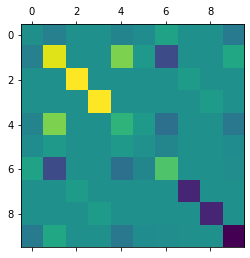

In [348]:
plt.matshow(dP_fd)

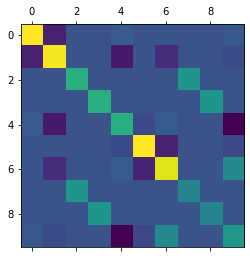

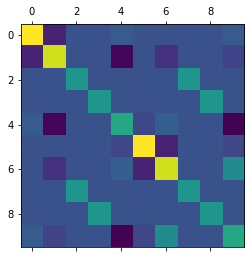

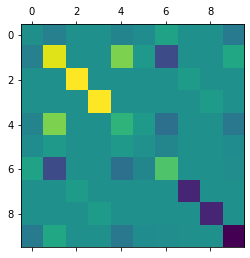

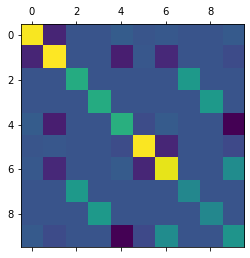

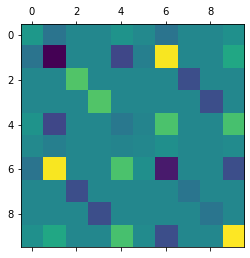

In [349]:
plt.matshow(P_on)
plt.matshow(P_nn)
plt.matshow(dP_fd)
plt.matshow(P_nn+dP_fd)
plt.matshow(P_on-dP_fd-P_nn)

In [350]:
#second order term
dP_fd2=(P(.05)+P(-.05)-2*P_nn)/.05**2

converged SCF energy = -108.39995410385
converged SCF energy = -106.591195211803


In [351]:
norm((P_nn+dP_fd+dP_fd2/2)-P_on),norm((P_nn+dP_fd)-P_on)

(0.13558187464874855, 0.17042041102717045)

In [361]:
dl=-.5
P_1=P(dl)
norm((P_nn+dP_fd*dl)-P_1),norm((P_nn+dP_fd*dl+dP_fd2*dl**2/2)-P_1)

converged SCF energy = -98.8338269134044


(0.036233824446497795, 0.01581799957091298)

In [356]:
#for i in np.linspace(-1,1,11):
#    P_i=P(i)
#    print("********\n",np.around(i,decimals=2),norm(P_i-P_on),norm(P_i-P_nn),"********\n")

In [357]:
np.einsum("ij,ij",P_nn,S_nn),np.einsum("ij,ij",P_nn+dP_fd,S_nn)

(14.0, 14.079330592447716)

In [358]:
np.einsum("ij,ij",P_on,S_on),np.einsum("ij,ij",P_nn+dP_fd,S_on)

(13.999999999999995, 13.98395154431946)

In [359]:
np.einsum("ij,ij",P_on,S_nn),np.einsum("ij,ij",P_nn,S_on)

(14.101250590877395, 13.888393736546732)

# On Analytical derivatives

In [454]:

def make_dP(mf,mo1):
    mol=mf.mol
    nao=mol.nao
    nocc=mf.mol.nelec[0]
    C=mf.mo_coeff
    dP=np.zeros_like(C)
    dP[:,:]=2*np.einsum('ij,jk,lk->il',C,mo1,C[:,:nocc])
    return dP+dP.T

def make_U(mo1):
    U=np.zeros((mo1.shape[0],mo1.shape[0]))
    U[:,:mo1.shape[1]]=mo1
    U=U-U.T
    return U

In [474]:
#The old code for nbs derivs
def alchemy_pol_deriv(polobj,dL, with_cphf=True):
    mf = polobj._scf
    mol = mf.mol
    mo_energy = mf.mo_energy
    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    occidx = mo_occ > 0
    orbo = mo_coeff[:, occidx]
    orbv = mo_coeff[:,~occidx]
    charges = mol.atom_charges()
    coords  = mol.atom_coords()
    charge_center = np.einsum('i,ix->x', charges, coords) / charges.sum()
    int_r=DeltaV(mol,dL)    ########   .001 as finite difference intervall  
    h1 = lib.einsum('xpq,pi,qj->xij', int_r, mo_coeff.conj(), orbo) #going to molecular orbitals?
    s1 = np.zeros_like(h1)
    vind = polobj.gen_vind(mf, mo_coeff, mo_occ)
    if with_cphf:
        mo1,e1 = cphf.solve(vind, mo_energy, mo_occ, h1, s1, polobj.max_cycle_cphf, polobj.conv_tol)
    else:
        mo1 = rhf_nmr._solve_mo1_uncoupled(mo_energy, mo_occ, h1, s1)[0]
    return mo1,e1[0]

In [513]:
#attempt to o this for luck







C=mf.mo_coeff
vind = mf.Polarizability().gen_vind(mf, C, O)
occidx = O > 0
orbo = C[:, occidx]
dh1_mo = lib.einsum('pq,pi,qj->ij', dh1, C.conj(), orbo) #going to molecular orbitals?
dS1_mo = lib.einsum('pq,pi,qj->ij', dS, C.conj(), orbo) #going to molecular orbitals?
dS1_mo =  np.zeros_like(dS1_mo)
mo1,e1 = cphf.solve(vind, e, O, -dh1[:,:7], dS1_mo[:,:7], 40 ,1e-8)

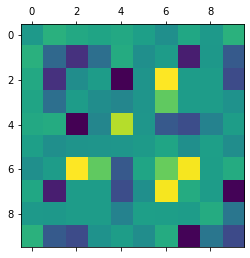

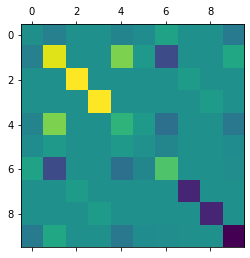

In [514]:
dP=make_dP(mf,mo1)
plt.matshow(dP)
plt.matshow(dP_fd)

In [501]:
norm(P_nn+dP),norm(P_nn+dP-P_on)

(8.638848705580328, 8.49916436182672)

In [483]:
import numpy
def solve_mo1(mf, mo_energy, mo_coeff, mo_occ, h1ao_or_chkfile,
              fx=None, atmlst=None, max_memory=4000, verbose=None):
    '''Solve the first order equation
    Kwargs:
        fx : function(dm_mo) => v1_mo
            A function to generate the induced potential.
            See also the function gen_vind.
    '''
    mol = mf.mol
    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:,mo_occ>0]
    nocc = mocc.shape[1]
    if fx is None:
        fx = mf.gen_vind(mf, mo_coeff, mo_occ)
    s1a = -mol.intor('int1e_ipovlp', comp=3)
    def _ao2mo(mat):
        return numpy.asarray([reduce(numpy.dot, (mo_coeff.T, x, mocc)) for x in mat])
    mem_now = lib.current_memory()[0]
    max_memory = max(2000, max_memory*.9-mem_now)
    blksize = max(2, int(max_memory*1e6/8 / (nmo*nocc*3*6)))
    mo1s = [None] * mol.natm
    e1s = [None] * mol.natm
    aoslices = mol.aoslice_by_atom()
    for ia0, ia1 in lib.prange(0, len(atmlst), blksize):
        s1vo = []
        h1vo = []
        for i0 in range(ia0, ia1):
            ia = atmlst[i0]
            shl0, shl1, p0, p1 = aoslices[ia]
            s1ao = numpy.zeros((3,nao,nao))
            s1ao[:,p0:p1] += s1a[:,p0:p1]
            s1ao[:,:,p0:p1] += s1a[:,p0:p1].transpose(0,2,1)
            s1vo.append(_ao2mo(s1ao))
            if isinstance(h1ao_or_chkfile, str):
                key = 'scf_f1ao/%d' % ia
                h1ao = lib.chkfile.load(h1ao_or_chkfile, key)
            else:
                h1ao = h1ao_or_chkfile[ia]
            h1vo.append(_ao2mo(h1ao)) 
        h1vo = numpy.vstack(h1vo)
        s1vo = numpy.vstack(s1vo)
        mo1, e1 = cphf.solve(fx, mo_energy, mo_occ, h1vo, s1vo)
        mo1 = numpy.einsum('pq,xqi->xpi', mo_coeff, mo1).reshape(-1,3,nao,nocc)
        e1 = e1.reshape(-1,3,nocc,nocc)

        for k in range(ia1-ia0):
            ia = atmlst[k+ia0]
            if isinstance(h1ao_or_chkfile, str):
                key = 'scf_mo1/%d' % ia
                lib.chkfile.save(h1ao_or_chkfile, key, mo1[k])
            else:
                mo1s[ia] = mo1[k]
            e1s[ia] = e1[k].reshape(3,nocc,nocc)
        mo1 = e1 = None
    return mo1s, e1s

In [512]:
mo1, mo_e1 = solve_mo1(mf, mf.mo_energy, mf.mo_coeff, mf.mo_occ,fx=vind,atmlst=[0])

TypeError: solve_mo1() missing 1 required positional argument: 'h1ao_or_chkfile'